In [1]:
import pandas as pd
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as ntx
import re
import altair as alt

# ref doc https://github.com/eliorc/node2ve and https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
from node2vec import Node2Vec 
from sklearn.model_selection import train_test_split
from music_utils import *
from tqdm.auto import tqdm  # import tqdm for progress bar
tqdm.pandas()

In [2]:
local = True
if local:
    DATA_PATH = '../Music_project/data/'
else:
    DATA_PATH = './data/'

In [3]:
def graph_largest_cc(nodes_df, plot_graph=False, write_graphml=None):   
    edge_list = [tuple(l[:2]) for l in nodes_df.values.tolist()]
    G = ntx.from_edgelist(edge_list)
    largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
    print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
    print(f'The largest connected component has {len(largest_cc.edges)} edges.')

    if plot_graph:
        fig, ax = plt.subplots(figsize=(15, 15))
        ntx.draw_networkx(largest_cc, with_labels=False, node_size = 20, ax = ax)
        plt.show()
    
    if write_graphml != None:
        ntx.write_graphml_lxml(G, write_graphml+'.graphml')
    return G, largest_cc

# Spotify 600k songs

In [8]:
spotify_600, artists_600 = read_spotify_600(DATA_PATH=DATA_PATH, read=False)

In order to keep only music, we will filter the songs based on the speechiness. Indeed, if a song is from an audio-book or so, it will have a high speechiness score. Hence, we will filter out songs that have a speechiness score that is higher than 0.7.

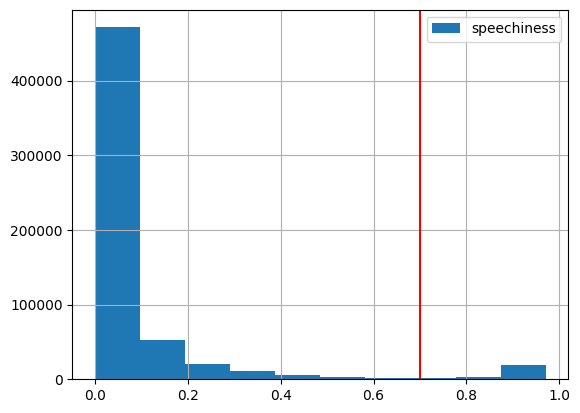

In [9]:
spotify_600["speechiness"].hist(legend = "Speechiness").axvline(x = 0.7, color = "red")

In [10]:
# Filter out non-music
n_non_music = sum(spotify_600["speechiness"] > 0.7)
print(f"We are deleting {n_non_music} songs from the dataframe")
spotify_600 = spotify_600[spotify_600["speechiness"] < 0.7]

#Nodes creation
feat_track_600 = spotify_600[(spotify_600.num_artists > 1)&(spotify_600.release_date.dt.year > 1999)].copy()
nodes_600 = nodes_featuring(feat_track_600, DATA_PATH=DATA_PATH, read=False, path='edge_list_600k_over1999.pkl')

#artists feature creation
artists_600_features = artists_features_creation(artists_600, spotify_600, DATA_PATH, read=False)

#Genres
genres = pd.DataFrame(artists_600_features.genres.explode().value_counts().reset_index()).dropna().rename(
    columns={'index':'genre','genres':'number_of_artists'}
)

We are deleting 22100 songs from the dataframe


In [42]:
pd.DataFrame(artists_600_features[(artists_600_features.solo_speechiness > 0.7)].genres.explode()).reset_index().groupby("genres").count().sort_values("artist_id", ascending=False)

,artist_id
genres,
kleine hoerspiel,34
poetry,23
disney horspiele,17
hoerspiel,15
barnmusik,14
...,...
dutch pop,1
dutch musical,1
dutch experimental,1


In [8]:
edge_list = [tuple(l[:2]) for l in nodes_600.values.tolist()]
G = ntx.from_edgelist(edge_list)
largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
print(f'The largest connected component has {len(largest_cc.edges)} edges.')

The largest connected component has 20805 nodes.
The largest connected component has 63630 edges.


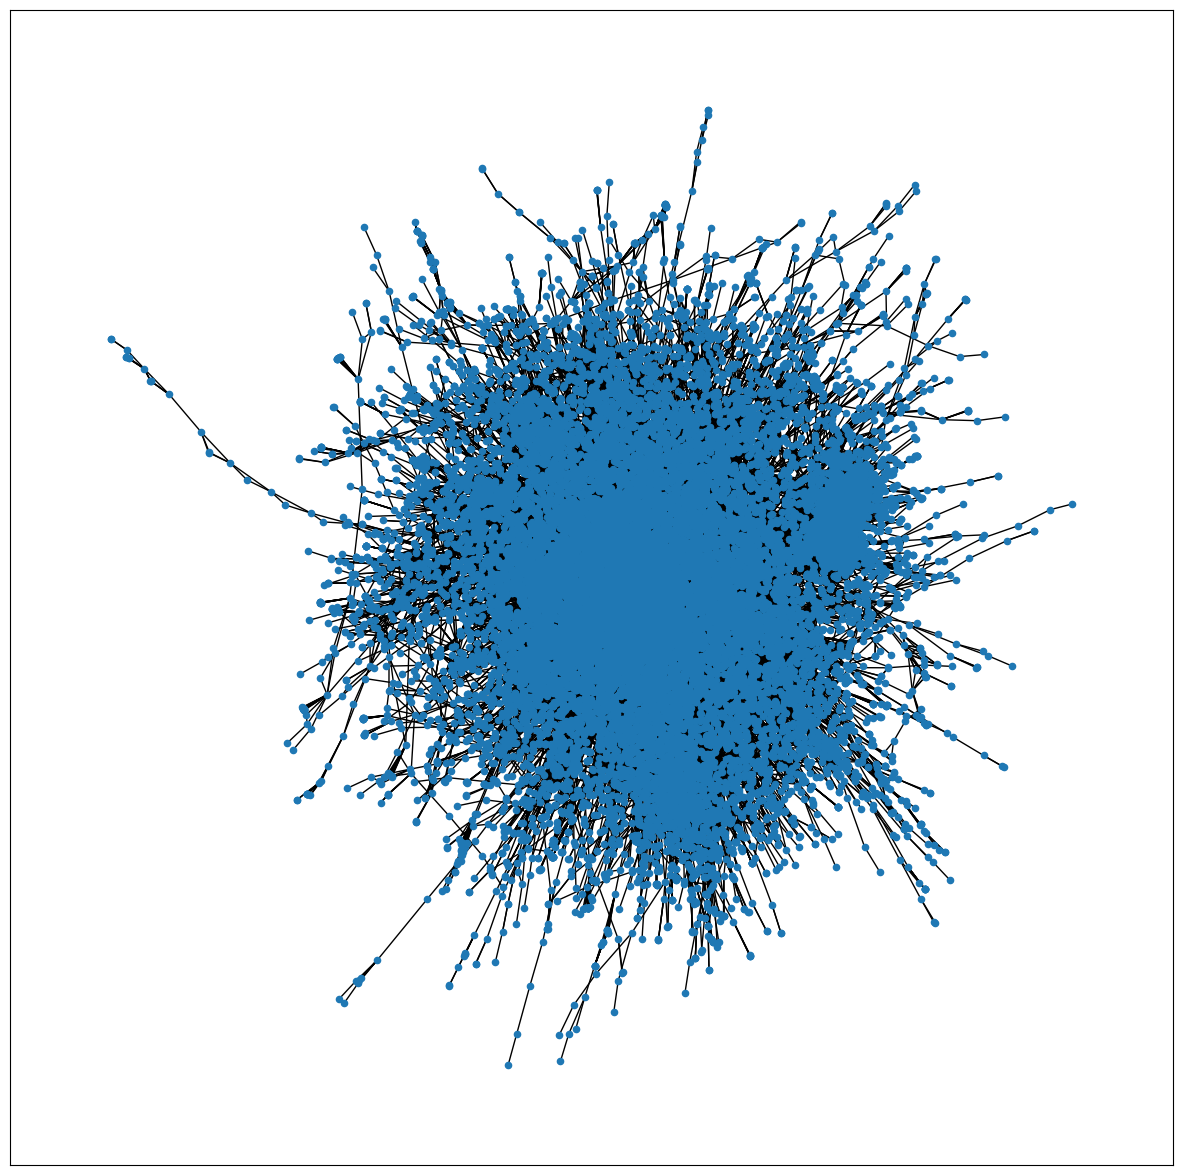

In [9]:
# didn't work on my local computer, but did work on colab, some issue with the installed networkx version
fig, ax = plt.subplots(figsize=(15, 15))
ntx.draw_networkx(largest_cc, with_labels=False, node_size = 20, ax = ax)

## Sub graph of french rap

In [ ]:
mask = artists_600_features['genres'].apply(lambda x: ('rap francais' in x) or ('french hip hop' in x))
# use the boolean mask to select the rows that contain 'rap francais' in the genres column
rap_francais_artists = artists_600_features[mask]
#the artists ids
french_rap_artist_ids = list(rap_francais_artists.index)

In [ ]:
#Nodes creation
# select rows where at least one element in the artist ids is in the french rapper list
french_rap_tracks = spotify_600[(spotify_600.num_artists > 1)].copy()
rap_mask = french_rap_tracks.id_artists.apply(lambda x: any(elem in french_rap_artist_ids for elem in x))
french_rap_tracks = french_rap_tracks[rap_mask]
# #every tracks where a french rapper is involved
nodes_french_rap = nodes_featuring(french_rap_tracks, DATA_PATH=DATA_PATH, read=False, path='edge_list_french_rap.pkl')

The largest connected component has 485 nodes.
The largest connected component has 1548 edges.


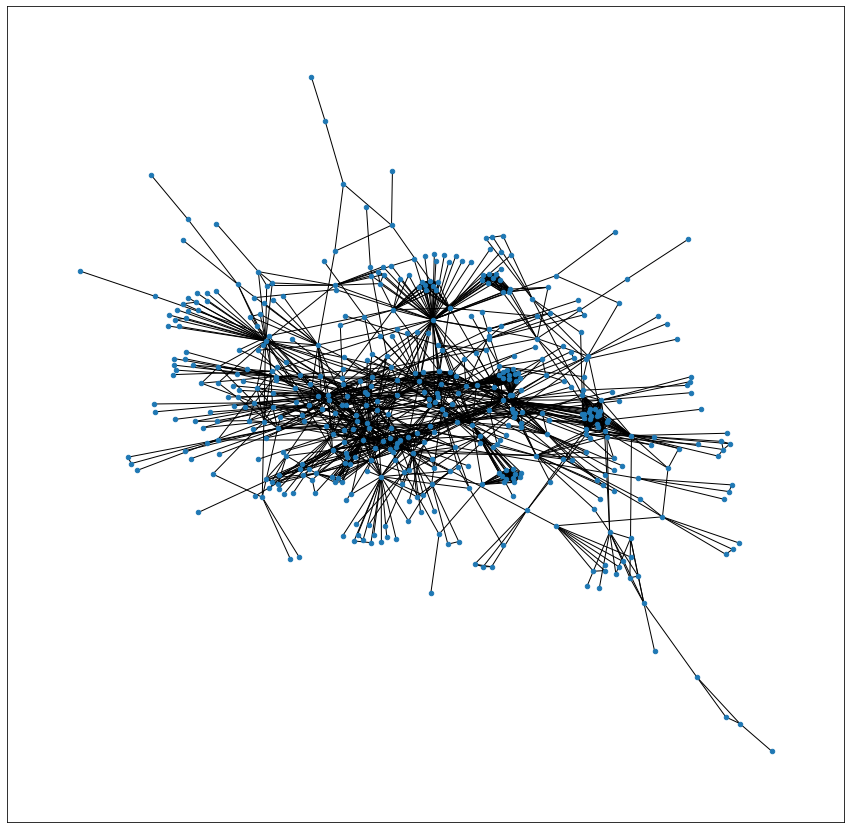

(<networkx.classes.graph.Graph at 0x7fe24c462580>,
 <networkx.classes.graph.Graph at 0x7fe255d43370>)

In [ ]:
graph_largest_cc(nodes_french_rap, plot_graph=True, write_graphml=DATA_PATH+'french_rap_G')

## Yearly graphs

In [11]:
spotify_600, artists_600 = read_spotify_600(DATA_PATH=DATA_PATH, read=True)

# Filter out non-music
n_non_music = sum(spotify_600["speechiness"] > 0.7)
print(f"We are deleting {n_non_music} songs from the dataframe")
spotify_600 = spotify_600[spotify_600["speechiness"] < 0.7]

#Nodes creation
#feat_track_600 = spotify_600[(spotify_600.num_artists > 1)&(spotify_600.release_date.dt.year > 1999)].copy()
#nodes_600 = nodes_featuring(feat_track_600, DATA_PATH=DATA_PATH, read=False, path='edge_list_600k_over1999.pkl')

We are deleting 22100 songs from the dataframe


In [14]:
spotify_600

,track_id,name,track_popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id,num_artists
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.4450,...,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,45tIt06XoI0Iio4LBEVpls,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,...,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,5LiOoJbxVSAMkBS2fUm3X2,1
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,...,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,5LiOoJbxVSAMkBS2fUm3X2,1
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922-01-01,0.402,0.1580,...,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,3BiJGZsyX9sJchTqcSA7Su,1
5,0BRXJHRNGQ3W4v9frnSfhu,Ave Maria,0,178933,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922-01-01,0.227,0.2610,...,1,0.0382,0.994,0.247000,0.0977,0.0539,118.891,4,3BiJGZsyX9sJchTqcSA7Su,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,[阿YueYue],[1QLBXKM5GCpyQQSVMNZqrZ],2020-09-26,0.560,0.5180,...,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,1QLBXKM5GCpyQQSVMNZqrZ,1
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,[ROLE MODEL],[1dy5WNgIKQU6ezkpZs4y8z],2020-10-21,0.765,0.6630,...,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,1dy5WNgIKQU6ezkpZs4y8z,1
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,[FINNEAS],[37M5pPGs6V1fchFJSgCguX],2020-09-02,0.535,0.3140,...,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,37M5pPGs6V1fchFJSgCguX,1
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"[Gentle Bones, Clara Benin]","[4jGPdu95icCKVF31CcFKbS, 5ebPSE9YI5aLeZ1Z2gkqjn]",2021-03-05,0.696,0.6150,...,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,4jGPdu95icCKVF31CcFKbS,2


In [19]:
spotify_600_oskar = spotify_600.copy()
spotify_600_oskar["year"] = [date.year for date in spotify_600_oskar.release_date]


In [21]:
min_year, max_year = min(spotify_600_oskar.year), max(spotify_600_oskar.year)
songs_by_year = {year: spotify_600_oskar[spotify_600_oskar.year == year] for year in range(min_year, max_year+1)}

In [23]:
songs_by_year[1999]

,track_id,name,track_popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id,num_artists,year
72438,48UPSzbZjgc449aqz8bxox,Californication,82,329733,0,[Red Hot Chili Peppers],[0L8ExT028jH3ddEcZwqJJ5],1999-06-08,0.592,0.767,...,0.0270,0.002100,0.001650,0.1270,0.3280,96.483,4,0L8ExT028jH3ddEcZwqJJ5,1,1999
72439,503OTo2dSqe7qk76rgsbep,Still D.R.E.,81,270587,1,"[Dr. Dre, Snoop Dogg]","[6DPYiyq5kWVQS4RGwxzPC7, 7hJcb9fa4alzcOq3EaNPoG]",1999-11-16,0.816,0.775,...,0.2340,0.160000,0.000310,0.0543,0.5270,93.431,4,6DPYiyq5kWVQS4RGwxzPC7,2,1999
72440,2m1hi0nfMR9vdGC8UcrnwU,All The Small Things,81,167067,0,[blink-182],[6FBDaR13swtiWwGhX1WQsP],1999-06-01,0.434,0.897,...,0.0488,0.010300,0.000000,0.6120,0.6840,148.726,4,6FBDaR13swtiWwGhX1WQsP,1,1999
72441,47BBI51FKFwOMlIiX6m8ya,I Want It That Way,80,213307,0,[Backstreet Boys],[5rSXSAkZ67PYJSvpUpkOr7],1999-05-18,0.689,0.694,...,0.0270,0.257000,0.000000,0.1480,0.4820,99.039,4,5rSXSAkZ67PYJSvpUpkOr7,1,1999
72442,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,80,211067,0,[Britney Spears],[26dSoYclwsYLMAKD3tpOr4],1999-01-12,0.759,0.699,...,0.0307,0.202000,0.000131,0.4430,0.9070,92.960,4,26dSoYclwsYLMAKD3tpOr4,1,1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586273,2soIF2zku6kTJsS6NJKhWy,Jesus Shall Take the Highest Honour,24,281600,0,[Chris Bowater],[1958AZQ040XhC08YgkQc8o],1999-01-01,0.399,0.339,...,0.0287,0.602000,0.000001,0.1770,0.0790,121.030,4,1958AZQ040XhC08YgkQc8o,1,1999
586274,6pB3a8jWm3PSaISWXJcCPg,Drive Me Crazy - Dindon Extended Mix,15,393627,0,[Espresso],[1ABeT0WKYR7MAua5NNhu1k],1999-04-28,0.638,0.912,...,0.0378,0.003430,0.000230,0.2020,0.8370,136.026,4,1ABeT0WKYR7MAua5NNhu1k,1,1999
586275,7LDQJXz2CrC1A8owVR1XvI,講什麼山盟海誓,15,253533,0,[Huang Yee Ling],[1R7Wis2hE4DXcTYaJsqM8J],1999-03-01,0.467,0.608,...,0.0314,0.090900,0.000000,0.3300,0.5250,78.705,4,1R7Wis2hE4DXcTYaJsqM8J,1,1999
586276,6EllOCJYmoKy2WH1Um9bMk,Sing Of Your Great Love,22,505680,0,[Hillsong Worship],[3SgHzT552wy2W8pNLaLk24],1999-07-01,0.326,0.322,...,0.0294,0.623000,0.000000,0.6940,0.0989,70.029,4,3SgHzT552wy2W8pNLaLk24,1,1999
